In [1]:
## general libraries 
import os,sys,glob
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
import dask.array as da

In [3]:
import math

In [4]:
import time

In [5]:
from mpl_toolkits.basemap import Basemap

In [6]:
# for plots
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

## ML libraries
# tensorflow
import tensorflow as tf
from tensorflow import keras
#print('tensorflow version:', tf.__version__) 

# keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense
from keras.utils.vis_utils import plot_model #CHANGE
#from keras.utils import plot_model #LAPTOP
import keras.backend as K
from tensorflow.python.training import checkpoint_utils as cp

#Extra libraries
from ann_visualizer.visualize import ann_viz
from itertools import chain

from mpl_toolkits import mplot3d
from sympy import symbols 
from sympy.utilities.lambdify import lambdify

print(f'Using Python  = {sys.version.split()[0]}')
print(f'Tensorflow    = {tf.__version__}')
print(f'Keras Version = {keras.__version__}')

Using Python  = 3.8.8
Tensorflow    = 2.8.0
Keras Version = 2.8.0


data_path = '//storage/ddiaz/2021/ATOC557rm/project/nonlinear_albedo_feedback_nn/era5_grid1_data/'


variables = ['tsr','tisr','tciw','tclw','tcwv','hcc','mcc','lcc','sp','tco3','fal']

TSR = xr.open_dataset(data_path+'TSR_era5.nc')

time = TSR.time

lon = TSR.longitude
lat = TSR.latitude

numlon = len(lon)
numlat = len(lat)
numy = len(time)
nvar = len(variables)

In [7]:
path = '//storage/ddiaz/2023/myProject/data/'
file = 'era5_monthly_avg_sl_2005-2020_tisr_tciw_tclw_tcwv_hcc_mcc_lcc_sp_tco3_fal_tsr.nc'
#file = 'era5_monthly_avg_pl_2005-2020_cc_ciwc_clwc.nc'
#file = 'era5_hourly_062016_pressurelevels.nc'
#file = 'era5_hourly_062016_single.nc'
#file = 'ALIIAera5_hourly_062016_single.nc'

In [8]:
xrr_sl = xr.open_dataset(path+file)
#even years for trainning
xrr_sl_even = xrr_sl.sel(time = ['2006','2008','2010','2012','2014','2016','2018','2020'])
#odd years for testing
x_rr_sl_odd = xrr_sl.sel(time = ['2005','2007','2009','2011','2013','2015','2017','2019'])

In [9]:
xrr_sl

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 192)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2005-01-01 2005-02-01 ... 2020-12-01
Data variables:
    fal        (time, latitude, longitude) float32 ...
    hcc        (time, latitude, longitude) float32 ...
    lcc        (time, latitude, longitude) float32 ...
    mcc        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    tisr       (time, latitude, longitude) float32 ...
    tsr        (time, latitude, longitude) float32 ...
    tciw       (time, latitude, longitude) float32 ...
    tclw       (time, latitude, longitude) float32 ...
    tco3       (time, latitude, longitude) float32 ...
    tcwv       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-04-03 23:21:47 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [10]:
df_train = xrr_sl_even.to_dataframe()

In [11]:
#To convert to W m-2 , the accumulated values should be divided by the accumulation period expressed in seconds
df_train.tisr = df_train.tisr/24/3600
df_train.tsr =df_train.tsr/24/3600

In [12]:
df_train

fal       hcc       lcc       mcc  \
latitude longitude time                                                 
 90.0    0.00      2006-01-01  0.759977  0.367996  0.834343  0.563842   
                   2008-01-01  0.728885  0.263914  0.970183  0.431599   
                   2010-01-01  0.756242  0.269072  0.878489  0.491237   
                   2012-01-01  0.731982  0.352208  0.959532  0.471674   
                   2014-01-01  0.756764  0.278135  0.870905  0.341873   
...                                 ...       ...       ...       ...   
-90.0    359.75    2012-01-01  0.849990  0.000950  0.330719  0.310673   
                   2014-01-01  0.850015  0.006771  0.309478  0.162318   
                   2016-01-01  0.849990  0.040610  0.225138  0.196559   
                   2018-01-01  0.849990  0.050442  0.335846  0.307281   
                   2020-01-01  0.849990  0.062914  0.349351  0.316068   

                                          sp        tisr         tsr  \
latitude longitude time                                                
 90.0    0.00      2006-01-01  100612.507812    0.000000    0.000000   
                   2008-01-01  101043.968750    0.000000    0.000000   
                   2010-01-01  101218.273438    0.000000    0.000000   
                   2012-01-01  101179.445312    0.000000    0.000000   
                   2014-01-01  101708.406250    0.000000    0.000000   
...                                      ...         ...         ...   
-90.0    359.75    2012-01-01   68547.523438  497.518616  140.575867   
                   2014-01-01   69508.812500  495.345551  142.580902   
                   2016-01-01   68781.375000  497.342407  140.764481   
                   2018-01-01   69167.093750  494.959625  142.958145   
                   2020-01-01   69450.132812  497.031952  143.978119   

                                   tciw      tclw      tco3      tcwv  
latitude longitude time                                                
 90.0    0.00      2006-01-01  0.032995  0.019288  0.008671  4.092861  
                   2008-01-01  0.019978  0.000323  0.007260  1.502850  
                   2010-01-01  0.021581  0.000311  0.008324  1.372780  
                   2012-01-01  0.028476  0.013927  0.007569  2.901909  
                   2014-01-01  0.017620  0.014202  0.007189  2.905300  
...                                 ...       ...       ...       ...  
-90.0    359.75    2012-01-01  0.004104  0.000060  0.006041  0.725845  
                   2014-01-01  0.002728  0.000060  0.006057  0.906807  
                   2016-01-01  0.004922  0.000012  0.006105  0.783524  
                   2018-01-01  0.006861  0.000203  0.006309  1.010857  
                   2020-01-01  0.004444  0.000036  0.006408  0.989368  

[8305920 rows x 11 columns]

#### We define input variables

In [13]:
# we use da.from_array() instead of np.array() since it uses less memory

tisr = np.array(df_train.tisr) 
tciw = np.array(df_train.tciw)
tclw = np.array(df_train.tclw)
tcwv = np.array(df_train.tcwv)
lcc = np.array(df_train.lcc)
mcc = np.array(df_train.mcc)
hcc = np.array(df_train.hcc)
sp = np.array(df_train.sp)
tco3 = np.array(df_train.tco3)
fal = np.array(df_train.fal)

In [14]:
tisr

array([  0.     ,   0.     ,   0.     , ..., 497.3424 , 494.95963,
       497.03195], dtype=float32)

#### Output variable

In [15]:
tsr = np.array(df_train.tsr)

#### Min Max normalization  

In [16]:
def MinMaxNorm(x,a,b):
    ''' Min-max normalization method between a specified range
        Normalization range = [a,b]
        x = input data
        a = lower range
        b = upper range 
        This method normalizes the input and output variables for the training of the NN'''
    
    n = (b-a)*(x-np.min(x))/(np.max(x)-np.min(x))+a
    return n

def MinMaxInverse(n,a,b,df):
    ''' Min-max inverse transform method 
        n = normalized data between [a,b]
        a = lower range
        b = upper range
        
        This method transforms the range of the predicted values using the NN, 
        from -1 to 1 to the correct range of the magnitude of the fnt of sw at TOA'''
    
    #we define the min and max values from the training dataset
    max_val = np.round(np.max(df.tsr),2)
    min_val = np.round(np.min(df.tsr),2)
    
    x = (n-a)*(max_val-min_val)/(b-a)+min_val
    return x

In [17]:
vars_list = [tisr, tciw, tclw, tcwv, lcc, mcc, hcc, sp, tco3 , fal]
vars_list_str = ['tisr', 'tciw', 'tclw', 'tcwv', 'lcc', 'mcc', 'hcc', 'sp', 'tco3' , 'fal']

type(vars_list)

#we combine the input variables into one merged array
merged_array = da.stack((vars_list), axis=1) #np.stack((vars_list), axis=1)

xx = merged_array
yy = tsr

In [18]:
max_val = np.round(np.max(tsr),2)
min_val = np.round(np.min(tsr),2)

# Normalization range [a,b]
#We set the normalization rate to be between -1 and 1, since the activation function (tanh) has the same range
a = -1
b = 1

nrmlzd_vars_list = []
for x in vars_list:    
    n = MinMaxNorm(x,a,b)
    nrmlzd_vars_list.append(n)

In [19]:
#we combine the input variables into one merged array
merged_array = np.stack((nrmlzd_vars_list), axis=1) #da.stack((nrmlzd_vars_list), axis=1)

In [20]:
len(nrmlzd_vars_list[0])

8305920

da.from_array?

### we define here the input and output variables for the NN

In [21]:
xx = merged_array
yy = MinMaxNorm(tsr,a,b) #we normalize the output

#### new early stopping method

In [22]:
from keras.callbacks import Callback

class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current <= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

#####  Function to train the NN

In [23]:
def runNN(x_values,y_real,alpha, iterations,shape_input,nodesLayer1, nodesLayer2, act_function1, act_function2, 
          earlyStopping, patienceEpochs, loss_thr ,dpii=80):
    
    start_time = time.time()
    
    # defining the tensors for the NN
    x=tf.constant(x_values) #albedo
    y=tf.constant(y_real) # prtrbd.fnt_sw_toa.to_numpy()
    
    # define the model
    model = tf.keras.Sequential(name='Sequential_NN')
    
    if nodesLayer2 == 0:
        layer1 = Dense(nodesLayer1,activation=act_function1 ,input_shape=[shape_input], name='hiddenLayer1') #11 relu
        output = Dense(1, name='output')

        model.add(layer1)
        model.add(output)
    
    else:
        layer1 = Dense(nodesLayer1,activation=act_function1 ,input_shape=[shape_input], name='hiddenLayer1') #11 relu
        layer2 = Dense(nodesLayer2,activation=act_function2, name='hiddenLayer2')
        output = Dense(1, name='output')

        model.add(layer1)
        model.add(layer2)
        model.add(output)

    # compile the model
    model.compile(loss='mse',
                  optimizer= tf.keras.optimizers.Adam(learning_rate=alpha), 
                  metrics=['accuracy'])

    # display the model
    model.summary()
    ann_viz(model, filename='figure_NN', title="Neural network")
    
    # save hyperparameters
    weights_dict = {}

    weight_callback = tf.keras.callbacks.LambdaCallback \
    ( on_epoch_end=lambda epoch, logs: weights_dict.update({epoch:model.get_weights()}))
    
    if earlyStopping==0:
        # fit the model
        history = model.fit( x, y, epochs=iterations, callbacks=[weight_callback],verbose=True)
    
    if earlyStopping== 1:
        #adding a callback to stop training 
        #es = EarlyStoppingByLossVal(monitor='loss', value=loss_thr, verbose=True)
        es = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1, mode='min', 
                                             patience=patienceEpochs)#min_delta=0.00001, start_from_epoch=10)
        # NEED TO CHECK THIS
        #es = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1, mode='min', 
                                              #baseline=loss_thr, min_delta=0.000001, patience=patienceEpochs)#min_delta=0.00001, start_from_epoch=10)

        # fit the model
        history = model.fit( x, y, epochs=iterations, callbacks=[weight_callback,es],verbose=True)
        #print(history.history)
    
    # get the learning rate value of the model
    lr= K.eval(model.optimizer.lr)

    # plot cost function
    plt.figure(figsize=(8,6),dpi=dpii)
    history_df = pd.DataFrame(history.history)

    plt.plot(history_df['loss'], label='cost')
    plt.yscale('log')

    plt.title('Training cost function with learning rate = '+ str(lr))
    plt.legend()
    plt.show()
    
    print("--- %s seconds ---" % (time.time() - start_time))
    
    return(model,history_df,weights_dict)

### Training and testing with all data

In [24]:
tf.random.set_seed(6)

lr = 0.001
itrtns = 90000
shp_inpt = merged_array.shape[1]
ndsLyr1 =3
ndsLyr2 =0
act_fnctn1 = 'tanh'
act_fnctn2 = 0
earlyStppng = 1                        # No = 0 , Yes = 1
ptnce = 100                             #100
lossTHR = 0.00002                      #0.00003 

In [25]:
merged_array.shape

(8305920, 10)

Patience = 500 for bivariate case

Model: "Sequential_NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hiddenLayer1 (Dense)        (None, 3)                 33        
                                                                 
 output (Dense)              (None, 1)                 4         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________
Epoch 1/90000
259560/259560 [==============================] - 285s 1ms/step - loss: 0.0014 - accuracy: 1.2040e-07
Epoch 2/90000
259560/259560 [==============================] - 286s 1ms/step - loss: 6.4290e-04 - accuracy: 1.2040e-07
Epoch 3/90000
259560/259560 [==============================] - 287s 1ms/step - loss: 6.4272e-04 - accuracy: 1.2040e-07
Epoch 4/90000
259560/259560 [==============================] - 282s 1ms/step - loss: 6.4276e-04 - ac

259560/259560 [==============================] - 274s 1ms/step - loss: 6.4280e-04 - accuracy: 1.2040e-07
Epoch 132/90000
259560/259560 [==============================] - 276s 1ms/step - loss: 6.4308e-04 - accuracy: 1.2040e-07
Epoch 133/90000
259560/259560 [==============================] - 274s 1ms/step - loss: 6.4292e-04 - accuracy: 1.2040e-07
Epoch 134/90000
259560/259560 [==============================] - 274s 1ms/step - loss: 6.4284e-04 - accuracy: 1.2040e-07
Epoch 135/90000
259560/259560 [==============================] - 276s 1ms/step - loss: 6.4320e-04 - accuracy: 1.2040e-07
Epoch 136/90000
259560/259560 [==============================] - 275s 1ms/step - loss: 6.4310e-04 - accuracy: 1.2040e-07
Epoch 137/90000
259560/259560 [==============================] - 274s 1ms/step - loss: 6.4308e-04 - accuracy: 1.2040e-07
Epoch 138/90000
259560/259560 [==============================] - 275s 1ms/step - loss: 6.4264e-04 - accuracy: 1.2040e-07
Epoch 139/90000
259560/259560 [=================

259560/259560 [==============================] - 274s 1ms/step - loss: 6.4287e-04 - accuracy: 1.2040e-07
Epoch 266/90000
259560/259560 [==============================] - 275s 1ms/step - loss: 6.4273e-04 - accuracy: 1.2040e-07
Epoch 267/90000
259560/259560 [==============================] - 273s 1ms/step - loss: 6.4287e-04 - accuracy: 1.2040e-07
Epoch 268/90000
259560/259560 [==============================] - 275s 1ms/step - loss: 6.4313e-04 - accuracy: 1.2040e-07
Epoch 269/90000
259560/259560 [==============================] - 274s 1ms/step - loss: 6.4289e-04 - accuracy: 1.2040e-07
Epoch 270/90000
259560/259560 [==============================] - 274s 1ms/step - loss: 6.4268e-04 - accuracy: 1.2040e-07
Epoch 271/90000
259560/259560 [==============================] - 273s 1ms/step - loss: 6.4304e-04 - accuracy: 1.2040e-07
Epoch 272/90000
259560/259560 [==============================] - 274s 1ms/step - loss: 6.4284e-04 - accuracy: 1.2040e-07
Epoch 273/90000
259560/259560 [=================

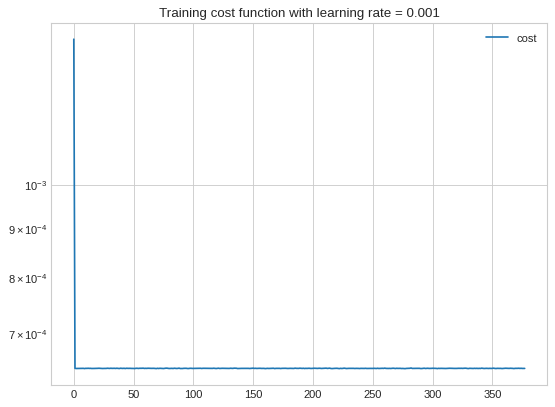

--- 105057.58188652992 seconds ---


In [26]:
model,history_df,weights_dict = runNN(xx, yy,
                                    alpha=lr,
                                    iterations=itrtns,
                                    shape_input=shp_inpt,
                                    nodesLayer1=ndsLyr1,
                                    nodesLayer2=ndsLyr2,
                                    act_function1=act_fnctn1,
                                    act_function2=act_fnctn2,
                                    earlyStopping=earlyStppng,   
                                    patienceEpochs=ptnce,
                                    loss_thr=lossTHR ) #we define the loss threshold but we are not using it

#### We save the model

In [27]:
# Save the entire model as a SavedModel.
# !mkdir -p saved_model

In [28]:
model.save('saved_model/nn_model_10i_1h_1o_ptnc100_8years_float32')

INFO:tensorflow:Assets written to: saved_model/nn_model_10i_1h_1o_ptnc100_8years_float32/assets


INFO:tensorflow:Assets written to: saved_model/nn_model_10i_1h_1o_ptnc100_8years_float32/assets


In [29]:
history_df['loss']

0      0.001418
1      0.000643
2      0.000643
3      0.000643
4      0.000643
         ...   
373    0.000643
374    0.000643
375    0.000643
376    0.000643
377    0.000643
Name: loss, Length: 378, dtype: float64

In [30]:
history_df['accuracy']

0      1.203961e-07
1      1.203961e-07
2      1.203961e-07
3      1.203961e-07
4      1.203961e-07
           ...     
373    1.203961e-07
374    1.203961e-07
375    1.203961e-07
376    1.203961e-07
377    1.203961e-07
Name: accuracy, Length: 378, dtype: float64

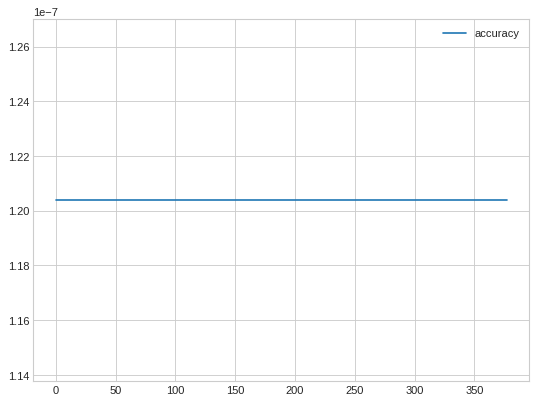

In [31]:
# plot accuracy
plt.figure(figsize=(8,6),dpi=80)

plt.plot(history_df['accuracy'], label='accuracy')
#plt.yscale('log')

#plt.title('Training cost function with learning rate = '+ str(lr))
plt.legend()
plt.show()

plt.figure(figsize=(8,6),dpi=300)

plt.plot(history_df['loss'], label='cost')
plt.yscale('log')

plt.title('Training cost function with learning rate = '+ str(lr))
plt.legend()
plt.show()

model.trainable_weights

#### Function to build the NN equation from the weight and biases outputs

In [32]:
nds_num = ndsLyr1
inpt_num = shp_inpt
inpt_list = vars_list_str
act_func = 'tanh'

# temp list as a container for each layer formulas
formula_list = []
frml_eqn = []
y_str = []
for ii in np.arange(len(model.layers)):
    # get ith Keras layer's weights and biases
    layer = model.layers[ii]
    WB = layer.get_weights()

    #WB[0].shape = (2,2)
    # empty text string to which concatenate current layer formula parts
    formula = ''
    if ii==0:
        
        for jj in np.arange(nds_num):
            weights = []
            all_terms = []
            
            for kk in np.arange(inpt_num):
                cur_weight = WB[0][kk][jj]
                cur_bias = WB[1][jj]
                weights.append(cur_weight)
                # build formula for this layer
                term = (str(np.round(weights[kk],2))+'*'+inpt_list[kk]+'+' )
                all_terms.append(term)
                
            bias = str(np.round(cur_bias,2))
            all_terms.append(bias)
            
            formula_list.append(all_terms)  
            


    elif ii == (len(model.layers)-1):
        for ll in np.arange(nds_num):
            act_term = ''
            for item in formula_list[ll]:
                act_term += str(item)
            y_str.append( str(np.round(WB[0][ll],2).squeeze()) + '*(np.'+ act_func+ '(' + act_term +'))+' )
               
        y_str.append(str(np.round(WB[1][0],2).squeeze()) )

equation = ''
for item in y_str:
    equation += str(item)

# make some cleanings
equation = equation.replace('+-','-')
equation = equation.replace('+*0.0*','')
equation = equation.replace('-*0.0*','')
str_equation = equation.replace('*','') 
str_equation = str_equation.replace('np.','') 

    
print(str_equation)

-0.73(tanh(-0.45tisr+0.02tciw-0.86tclw-0.12tcwv-0.0lcc-0.02mcc-0.05hcc-0.07sp+0.07tco3+0.49fal-1.03))+0.54(tanh(0.49tisr+0.2tciw-1.64tclw-0.33tcwv-0.02lcc-0.04mcc-0.12hcc-0.15sp+0.1tco3+0.87fal-0.84))+1.21(tanh(0.5tisr-0.21tciw+0.15tclw+0.19tcwv-0.13lcc-0.12mcc-0.01hcc-0.02sp-0.01tco3-0.7fal-1.39))+0.23


#### We test the NN with the odd years 

In [ ]:
df_test = x_rr_sl_odd.to_dataframe()

In [ ]:
df_test.tisr = df_test.tisr/24/3600
df_test.tsr =df_test.tsr/24/3600

vars_list_test =  [ np.array(df_test.tisr), np.array(df_test.tciw), np.array(df_test.tclw), np.array(df_test.tcwv), 
                   np.array(df_test.lcc), np.array(df_test.mcc), np.array(df_test.hcc), np.array(df_test.sp), 
                   np.array(df_test.tco3), np.array(df_test.fal)]

tsr_test = np.array(df_test.tsr)

max_val_test = np.round(np.max(tsr_test),2)
min_val_test = np.round(np.min(tsr_test),2)

# Normalization range [a,b]
#We set the normalization rate to be between -1 and 1, since the activation function (tanh) has the same range
a = -1
b = 1

nrmlzd_vars_list_test = []
for x in vars_list_test:    
    n = MinMaxNorm(x,a,b)
    nrmlzd_vars_list_test.append(n)

#we combine the input variables into one merged array
merged_array_test = np.stack((nrmlzd_vars_list_test), axis=1) #da.stack((nrmlzd_vars_list), axis=1)

In [ ]:
xx_test = merged_array_test
yy_test = MinMaxNorm(tsr_test,a,b) #we normalize the output

In [ ]:
#predictions
prdctns=model.predict(xx_test)
#inverse transform
prdctnss = MinMaxInverse(prdctns,a,b,df_test)

In [ ]:
df_lat_lon = df_test.reset_index(level = ['latitude','longitude'])

In [ ]:
df_lat_lon['NN_predictions'] = prdctnss

In [ ]:
df_lat_lon.to_csv('df_test_3n_100ptnc_8years_float32.csv')

In [40]:
from itertools import chain

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

<ipython-input-41-ff17bc0a1049>:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, alpha=0.5)


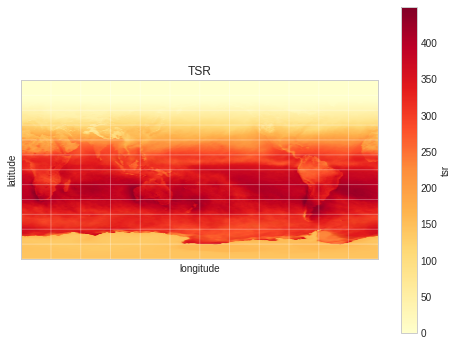

In [41]:
# initialize an axis
fig, ax = plt.subplots(figsize=(8,6), edgecolor='w')

# plot map on axis
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=0, urcrnrlon=360, )
draw_map(m)

# plot points
df_lat_lon.plot(x="longitude", y="latitude", kind="scatter", 
        c="tsr", colormap="YlOrRd", 
        title="TSR", 
        ax=ax)

# title=f"Fires in Australia {first_month} to {last_month}"

# add grid
ax.grid(b=True, alpha=0.5)
plt.show()

<ipython-input-42-6a9ce95def59>:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, alpha=0.5)


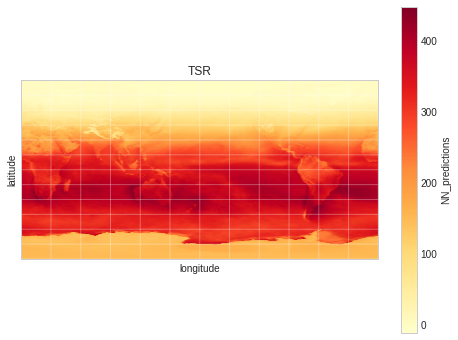

In [42]:
# initialize an axis
fig, ax = plt.subplots(figsize=(8,6), edgecolor='w')

# plot map on axis
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=0, urcrnrlon=360, )
draw_map(m)

# plot points
df_lat_lon.plot(x="longitude", y="latitude", kind="scatter", 
        c="NN_predictions", colormap="YlOrRd", 
        title="TSR", 
        ax=ax)

# title=f"Fires in Australia {first_month} to {last_month}"

# add grid
ax.grid(b=True, alpha=0.5)
plt.show()

In [ ]:
MBE = np.mean(prdctnss-df_test.tsr.values)
print('MBE: ',np.round(MBE,4))

In [21]:
I = (df.eff_tau_ice+df.eff_tau_liq)
II = (df.eff_tau_ice+df.eff_tau_liq)*df.albedo
III = df.albedo

V = df.fnt_sw_toa #z_interp

In [ ]:
plt.figure(figsize=(6,6),dpi=300)

ax = plt.axes(projection='3d')
ax.scatter3D(I,II,V,label='rrtmg values',s=0.1)
ax.scatter3D(I,II,prdctnss,label='predictions with the NN',s=0.1)

plt.legend(loc='upper right')
plt.title('fnt_sw_toa('+vars_list_str[0]+','+vars_list_str[1]+','+vars_list_str[2] +')')
plt.xlabel(vars_list_str[0])
plt.ylabel(vars_list_str[1])

ax.view_init(5, 333) #333

plt.show()

In [48]:
#prueba = xr.open_dataset(data_path+variables[7].upper()+'_era5.nc')